In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
data = pd.read_csv("data_2002_2024.csv")
data

,team,season,week,total_yards,def_yards_allowed,turnovers,possession_time,pass_yards,rush_yards,third_down_pct,redzone_pct,point_diff,ypp,result,is_champion
0,49ers,2002,17,329,263,2,2137,136,193,0.428571,0.000000,-11,5.222222,0,0
1,49ers,2002,16,358,184,2,2059,252,106,0.550000,0.000000,3,4.904110,1,0
2,49ers,2002,15,263,302,1,1437,156,107,0.461538,0.000000,-6,4.614035,0,0
3,49ers,2002,14,401,257,1,2159,276,125,0.500000,0.000000,4,4.717647,1,0
4,49ers,2002,13,299,507,2,1945,157,142,0.562500,0.000000,7,4.397059,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7355,Vikings,2024,13,273,406,1,1451,205,68,0.125000,0.500000,1,5.352941,1,0
7356,Vikings,2024,12,452,398,1,2006,328,124,0.461538,0.428571,3,6.953846,1,0
7357,Vikings,2024,11,318,294,1,1951,236,82,0.357143,1.000000,10,4.746269,1,0
7358,Vikings,2024,10,402,143,3,2539,233,169,0.357143,0.000000,5,4.902439,1,0


In [3]:
# Load dicts
with open("playoff_dict.json") as f:
    playoff_dict = json.load(f)
playoff_dict = {int(k): v for k, v in playoff_dict.items()}

with open("finalists_dict.json") as f:
    finalists_dict = json.load(f)
finalists_dict = {int(k): v for k, v in finalists_dict.items()}

with open("champions_dict.json") as f:
    champions_dict = json.load(f)
champions_dict = {int(k): v for k, v in champions_dict.items()}

with open("division_winners_dict.json") as f:
    division_winners_dict = json.load(f)
division_winners_dict = {int(k): v for k, v in division_winners_dict.items()}

In [4]:
# Function to get training data
def get_training_data(data, season, year_back, playoff_dict, top_seed_dict):
    # Select data from past seasons within the training window size
    train = data[(data["season"] < season) & (data["season"] >= (season - year_back))].copy()
    
    # Create playoff label: 1 if team made the playoffs, else 0
    train["is_playoff"] = train.apply(lambda row: int(row["team"] in playoff_dict.get(row["season"], [])), axis=1)

    # Separate features and labels for playoff model
    X_playoff = train.drop(columns=["team", "season", "week", "result", "is_champion", "is_playoff"])
    y_playoff = train["is_playoff"]

    # Subset only playoff teams for champion model
    X_champion = X_playoff[y_playoff == 1]
    y_champion = train["is_champion"][y_playoff == 1]

    # Assign higher weight to top seed teams
    sample_weights = train.apply(
    lambda row: 2.5 if row["team"] in top_seed_dict.get(row["season"], []) else 1.0,
    axis=1
    )
    sample_weights = sample_weights[y_playoff == 1]

    return X_playoff, y_playoff, X_champion, y_champion, sample_weights


# Function to train the two-stage model (playoff model and champion model)
def train_models(X, y_playoff, X_champion, y_champion, sample_weights):
    # Train playoff prediction model
    playoff_model = XGBClassifier(eval_metric="logloss", random_state=42)
    playoff_model.fit(X, y_playoff)

    # Train champion prediction model using playoff teams with weighted samples
    champion_model = XGBClassifier(eval_metric="logloss", random_state=42)
    champion_model.fit(X_champion, y_champion, sample_weight=sample_weights)

    return playoff_model, champion_model


# Function to get season data for prediction
def get_season_data(data, season, year_back):
    # Select seasons within the training window size
    relevant_seasons = [season - i for i in range(1, year_back + 1)]
    season_data = data[data["season"].isin(relevant_seasons)]

    # Calculate number of games per team
    games_per_team = season_data.groupby("team")["week"].count().rename("games_played")

    # Aggregate team-level statistics
    season_data = season_data.groupby("team").agg({
        'total_yards': 'mean',
        'def_yards_allowed': 'mean',
        'turnovers': 'sum',
        'possession_time': 'mean',
        'pass_yards': 'mean',
        'rush_yards': 'mean',
        'third_down_pct': 'mean',
        'redzone_pct': 'mean',
        'point_diff': 'sum',
        'ypp': 'mean'
    })

    # Normalise turnover and point differential per game
    season_data = season_data.merge(games_per_team, left_index=True, right_index=True)
    season_data["turnovers"] = season_data["turnovers"] / season_data["games_played"]
    season_data["point_diff"] = season_data["point_diff"] / season_data["games_played"]
    season_data = season_data.drop(columns=["games_played"])
    
    return season_data.reset_index()


# Function to predict, rank, and evaluate predictions for a season
def predict_two_stage(playoff_model, champion_model, season_data, season, champions_dict, year):
    # Prepare input features for prediction
    X_test = season_data.drop(columns=["team"])

    # Stage 1: Predict playoff probabilities
    playoff_probs = playoff_model.predict_proba(X_test)[:, 1]

    # Stage 2: Predict champion probabilities
    champ_probs = champion_model.predict_proba(X_test)[:, 1]

    # Final probability: multiply playoff and champion probabilities
    final_probs = playoff_probs * champ_probs

    # Create ranking dataframe
    ranked = season_data[["team"]].copy()
    ranked["prob"] = final_probs
    ranked["is_champion"] = ranked["team"] == champions_dict.get(season)

    # Sort teams by predicted probability
    ranked = ranked.sort_values("prob", ascending=False).reset_index(drop=True)

    # Create y_true and y_pred for probabilistic metrics
    y_true = (ranked["is_champion"] == 1).astype(int).tolist()
    y_pred = ranked["prob"].tolist()

    # Calculate total probability for normalisation
    total_prob = ranked["prob"].sum()
    
    # Return evaluation metrics
    return {
        "superbowl_year": season,
        "n_seasons_history": year,
        "model_pick_team": ranked.iloc[0]["team"],
        "model_pick_prob": ranked.iloc[0]["prob"] / total_prob,
        "is_prediction_correct": ranked.iloc[0]["is_champion"] == 1,
        "is_champion_in_top2": (ranked[ranked["is_champion"] == 1].index[0] + 1) <= 2,
        "is_champion_in_top7": (ranked[ranked["is_champion"] == 1].index[0] + 1) <= 7,
        "champion_team": champions_dict.get(season),
        "true_prob": ranked[ranked["is_champion"] == 1]["prob"].iloc[0] / total_prob,
        "y_true": y_true,
        "y_pred": [p / total_prob for p in y_pred],
        "team_names": ranked["team"].tolist()
    }


# Main function to evaluate two-stage model over multiple historical periods and seasons
def evaluate_two_stage_all_years(data, playoff_dict, champions_dict, top_seed_dict):
    all_results = []
    playoff_models = {}
    champion_models = {}

    # Loop over all historical window sizes
    for year_back in [1, 2, 3, 4, 7, 10, 12]:
        results = []

        # Evaluate for each season
        for season in range(2019,2025):
            # Prepare training data
            X_playoff, y_playoff, X_champion, y_champion, sample_weights = get_training_data(
                data, season, year_back, playoff_dict, top_seed_dict
            )
            
            # Train models
            playoff_model, champion_model = train_models(
                X_playoff, y_playoff, X_champion, y_champion, sample_weights
            )

            # Store models
            playoff_models[(year_back, season)] = playoff_model
            champion_models[(year_back, season)] = champion_model

            # Prepare test data and evaluate
            season_data = get_season_data(data, season, year_back)
            result = predict_two_stage(playoff_model, champion_model, season_data, season, champions_dict, year_back)
            results.append(result)

        # Append season results to overall results
        all_results.extend(results)
    
    return pd.DataFrame(all_results), playoff_models, champion_models

all_results, playoff_models, champion_models = evaluate_two_stage_all_years(
    data, playoff_dict, champions_dict, division_winners_dict)

In [5]:
# Calculate metrics for a single window size
def calculate_metrics_for_group(group):
    # Extract list of y_true and y_pred lists for all seasons
    y_trues = group["y_true"].tolist()
    y_preds = group["y_pred"].tolist()

    # Flatten nested lists into single lists
    y_true = [item for sublist in y_trues for item in sublist]
    y_pred = [item for sublist in y_preds for item in sublist]

    # Return all metrics as a pandas Series
    return pd.Series({
        "Top 1 Accuracy": group["is_prediction_correct"].mean(),
        "Top 2 Accuracy": group["is_champion_in_top2"].mean(),
        "Top 7 Accuracy": group["is_champion_in_top7"].mean(),
        "Weighted Contender Score (WCS)": group["is_prediction_correct"].mean() * 0.45 +
                                          group["is_champion_in_top2"].mean() * 0.35 +
                                          group["is_champion_in_top7"].mean() * 0.2,
        "AUC": roc_auc_score(y_true, y_pred),
        "LogLoss": log_loss(y_true, y_pred, labels=[0, 1]),
        "Brier Score": brier_score_loss(y_true, y_pred)
    })

# Compute probabilistic metrics for all window sizes
def compute_probabilistic_metrics(all_results):
    # Group by window size (n_seasons_history) and apply metrics function
    metrics_df = all_results.groupby("n_seasons_history").apply(
        calculate_metrics_for_group
    ).reset_index()

    # Rename column for clarity
    metrics_df.rename(columns={"n_seasons_history": "Window Size"}, inplace=True)
    
    return metrics_df

metrics_df = compute_probabilistic_metrics(all_results)
metrics_df.round(4)

,Window Size,Top 1 Accuracy,Top 2 Accuracy,Top 7 Accuracy,Weighted Contender Score (WCS),AUC,LogLoss,Brier Score
0,1,0.1667,0.3333,0.5000,0.2917,0.7437,0.1495,0.0309
1,2,0.0000,0.1667,0.3333,0.1250,0.7464,0.1559,0.0348
2,3,0.1667,0.3333,0.6667,0.3250,0.8513,0.1373,0.0358
3,4,0.1667,0.3333,0.8333,0.3583,0.8109,0.1398,0.0349
4,7,0.0000,0.1667,0.5000,0.1583,0.6918,0.1583,0.0351
5,10,0.0000,0.0000,0.0000,0.0000,0.5215,0.1876,0.0380
6,12,0.0000,0.0000,0.3333,0.0667,0.5690,0.1716,0.0355


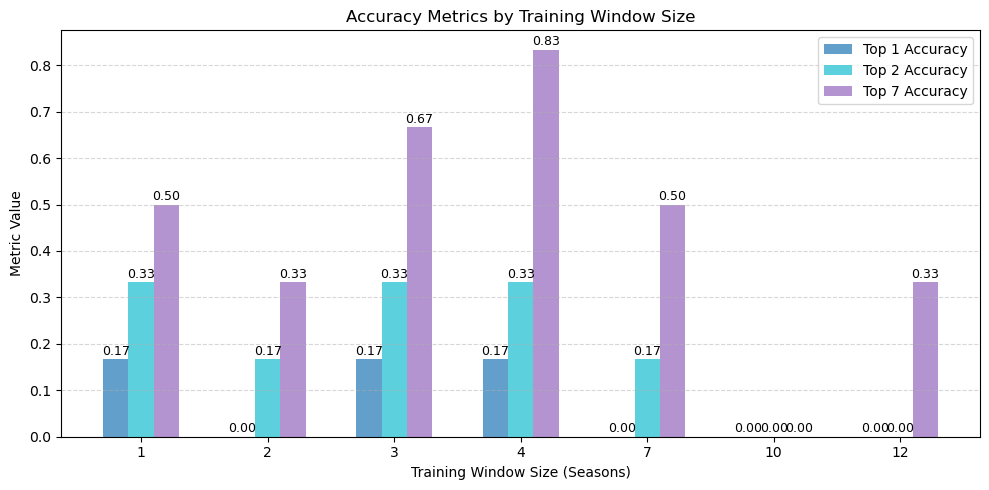

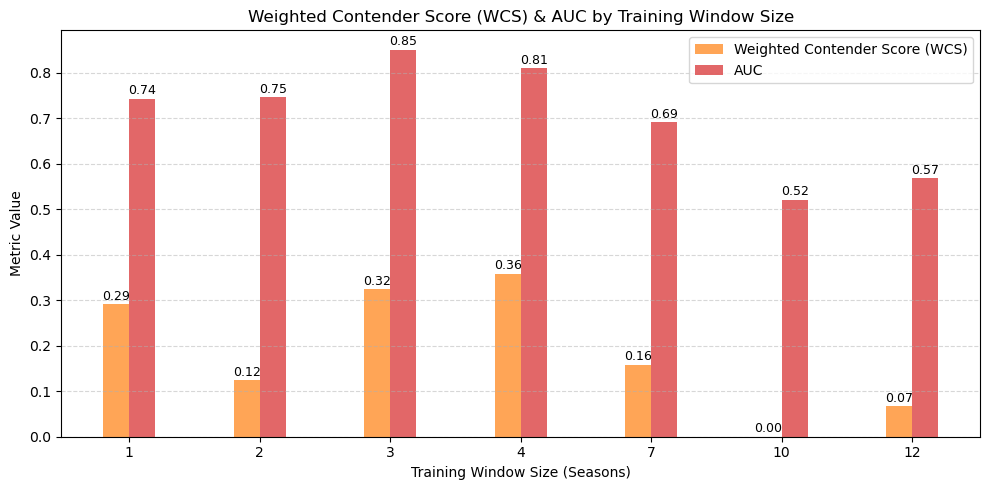

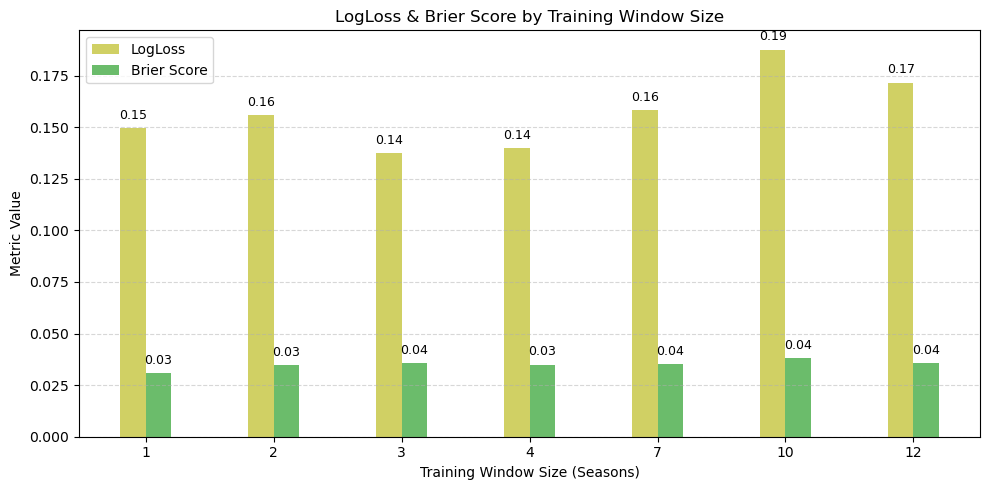

In [6]:
# Plots grouped bar charts to compare performance metrics across training window sizes
def plot_metric_group(metrics_df, metrics, title, bar_width=0.2):
    # Define color mapping for each metric
    colors = {
        "Top 1 Accuracy": 'tab:blue',
        "Top 2 Accuracy": 'tab:cyan',
        "Top 7 Accuracy": 'tab:purple',
        "Weighted Contender Score (WCS)": 'tab:orange',
        "AUC": 'tab:red',
        "LogLoss": 'tab:olive',
        "Brier Score": 'tab:green'
    }

    # Extract window sizes and setup x-axis positions
    windows = metrics_df['Window Size']
    x = np.arange(len(windows))

    # Plot bars for each selected metric
    plt.figure(figsize=(10, 5))
    for i, metric in enumerate(metrics):
        offset = i * bar_width
        bar_x = x + offset
        values = metrics_df[metric]
        plt.bar(bar_x, values, width=bar_width, label=metric, color=colors[metric], alpha=0.7)

        # Add value labels above each bar
        for x_pos, val in zip(bar_x, values):
            plt.text(x_pos, val + 0.003, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

    # Axis and grid settings
    plt.xticks(x + bar_width * (len(metrics) - 1) / 2, windows)
    plt.title(title)
    plt.xlabel("Training Window Size (Seasons)")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_metric_group(metrics_df, ["Top 1 Accuracy", "Top 2 Accuracy", "Top 7 Accuracy"], "Accuracy Metrics by Training Window Size")
plot_metric_group(metrics_df, ["Weighted Contender Score (WCS)", "AUC"], "Weighted Contender Score (WCS) & AUC by Training Window Size")
plot_metric_group(metrics_df, ["LogLoss", "Brier Score"], "LogLoss & Brier Score by Training Window Size")

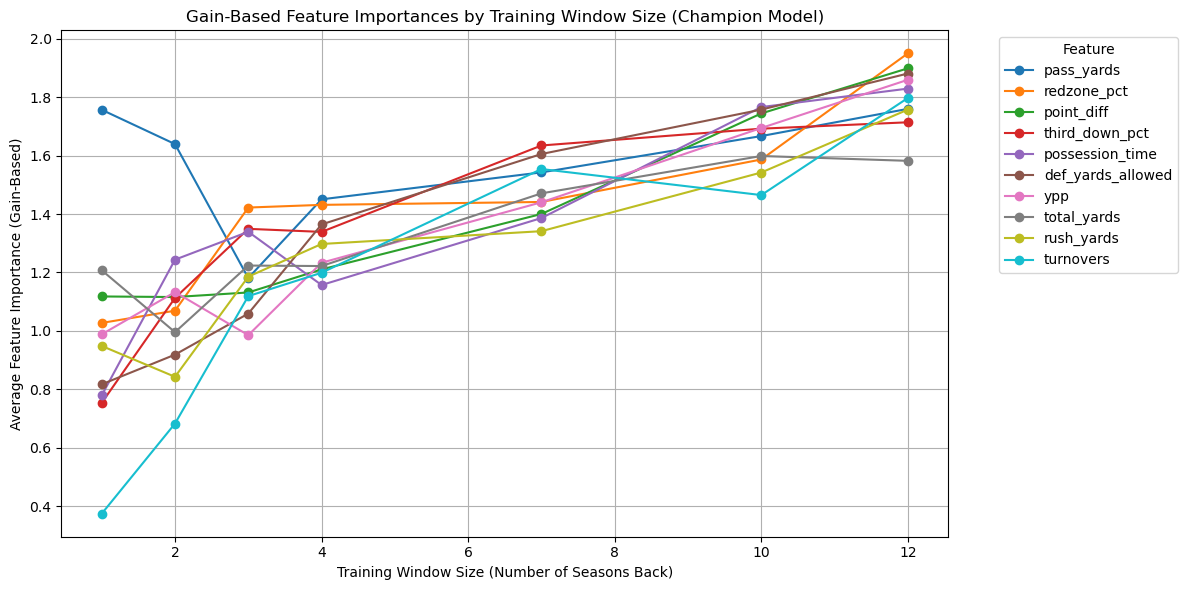

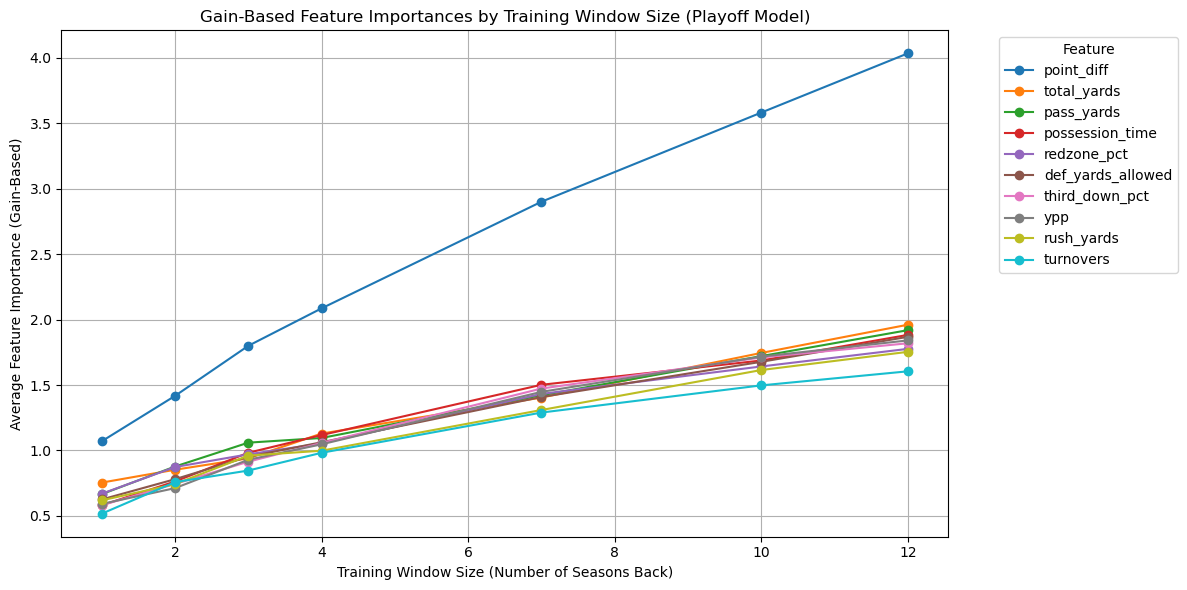

In [7]:
# Plots the average feature importances
def plot_feature_importances(models, model_type):
    # List of feature names used in the models
    feature_names = ["total_yards", "def_yards_allowed", "turnovers", "possession_time", "pass_yards", "rush_yards", "third_down_pct", "redzone_pct", "point_diff", "ypp"]

    # Collect feature importances from each model
    rows = []
    for (year_back, season), model in models.items():
        booster = model.get_booster()
        # Get feature importances based on 'gain'
        score_dict = booster.get_score(importance_type='gain')

        # Build row: include 0.0 for features not used in splits
        row = {"year_back": year_back}
        for f in feature_names:
            row[f] = score_dict.get(f, 0.0)
        rows.append(row)

    # Create DataFrame from all rows
    df = pd.DataFrame(rows)

    # Calculate average feature importance per training window size
    avg_df = df.groupby("year_back").mean(numeric_only=True)

    # Sort features by overall average importance (descending)
    mean_importance = avg_df.mean(axis=0).sort_values(ascending=False)
    avg_df = avg_df[mean_importance.index]

    # Plot feature importances as line plots
    plt.figure(figsize=(12, 6))
    for feature in avg_df.columns:
        plt.plot(avg_df.index, avg_df[feature], marker='o', label=feature)

    # Plot formatting
    plt.title(f"Gain-Based Feature Importances by Training Window Size ({model_type} Model)")
    plt.xlabel("Training Window Size (Number of Seasons Back)")
    plt.ylabel("Average Feature Importance (Gain-Based)")
    plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_feature_importances(champion_models, model_type='Champion')
plot_feature_importances(playoff_models, model_type='Playoff')

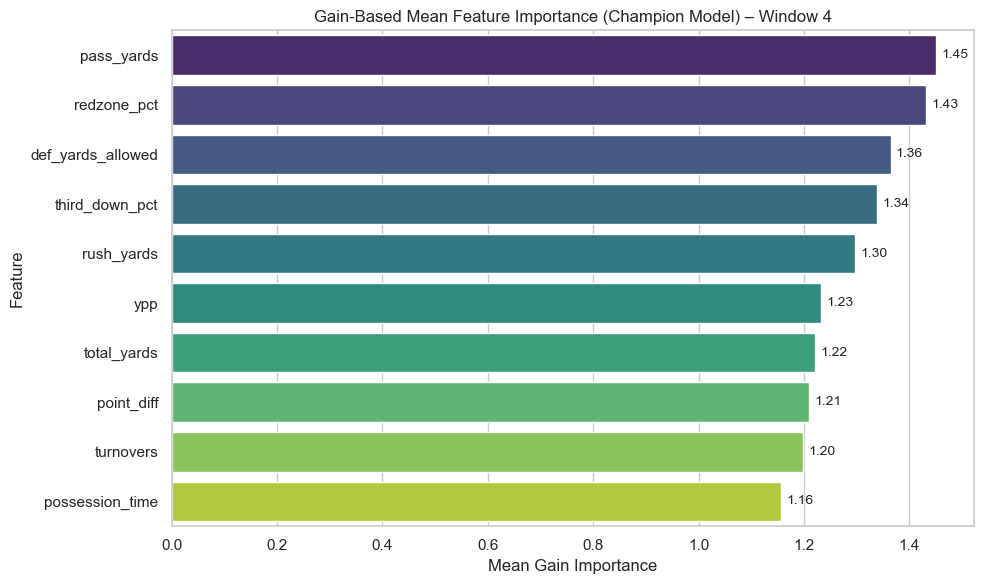

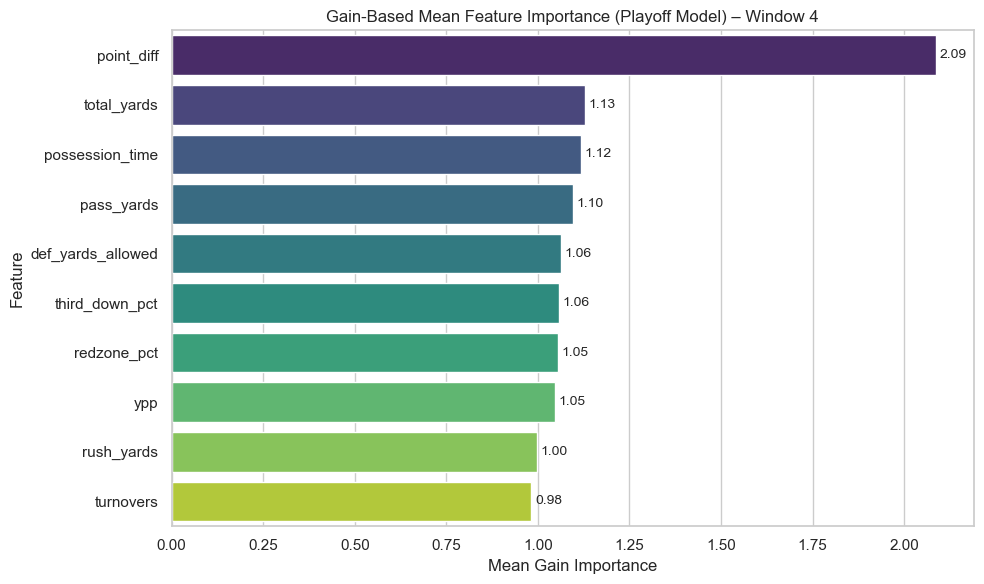

In [15]:
# Plots the mean feature importance for all models trained with a specific window size
def plot_window_feature_importance(models, window, model_type):
    # Collect feature importances for the specified window
    rows = []
    for (year_back, season), model in models.items():
        if year_back != window:
            continue
        booster = model.get_booster()
        importance_dict = booster.get_score(importance_type='gain')

        # Store feature importances
        for feature_name, importance in importance_dict.items():
            rows.append({
                'window': window,
                'season': season,
                'feature': feature_name,
                'importance': importance
            })

    # Create DataFrame of importances
    df = pd.DataFrame(rows)
    
    # Calculate mean importance per feature
    mean_imp = (df.groupby('feature')['importance'].mean().sort_values(ascending=False))

    # Plot barplot
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("viridis", len(mean_imp))
    sns.set(style="whitegrid")
    ax = sns.barplot(x=mean_imp.values, y=mean_imp.index, palette=colors)

    # Add value labels
    for i, (val, label) in enumerate(zip(mean_imp.values, mean_imp.index)):
        ax.text(val + 0.01, i, f"{val:.2f}", va='center', fontsize=10)

    plt.title(f'Gain-Based Mean Feature Importance ({model_type} Model) – Window {window}')
    plt.xlabel('Mean Gain Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

plot_window_feature_importance(champion_models, window=4, model_type='Champion')
plot_window_feature_importance(playoff_models, window=4, model_type='Playoff')

In [ ]:
# Computes combined SHAP values for a two-stage model across all seasons for a given window size
def compute_combined_shap_values(
    data, playoff_models, champion_models, playoff_dict, champions_dict, top_seed_dict, window
):
    rows = []

    # Loop through all seasons
    for season in range(2019,2025):    
        key = (window, season)
        playoff_model = playoff_models[key]
        champion_model = champion_models[key]

        # Get training data
        X_playoff, y_playoff, X_champion, y_champion, sample_weights = get_training_data(
            data, season, window, playoff_dict, division_winners_dict
        )

        # Predict playoff (f1) and champion (f2) probabilities
        f1 = playoff_model.predict_proba(X_playoff)[:, 1]
        f2_full = champion_model.predict_proba(X_playoff)[:, 1]
        
        # Predict on playoff teams for champion model
        f1_champion = playoff_model.predict_proba(X_champion)[:, 1]
        f2_champion = champion_model.predict_proba(X_champion)[:, 1]

        # Compute SHAP values
        explainer1 = shap.Explainer(playoff_model, X_playoff, model_output="probability")
        shap1 = explainer1(X_playoff).values
        
        explainer2 = shap.Explainer(champion_model, X_champion, model_output="probability")
        shap2_partial = explainer2(X_champion).values

        # Create mapping of SHAP values for playoff teams
        shap2_dict = {idx: shap2_partial[i] for i, idx in enumerate(X_champion.index)}

        # Calculate combine SHAP values for all teams
        for i, idx in enumerate(X_playoff.index):
            s1 = shap1[i]
            f1_i = f1[i]
            f2_i = f2_full[i]
            s2 = shap2_dict[idx] if idx in shap2_dict else np.zeros_like(s1)
            shap_final = s1 * f2_i + s2 * f1_i

            # Store absolute SHAP values
            for j, feature in enumerate(X_playoff.columns):
                rows.append({
                    "season": season,
                    "feature": feature,
                    "mean_abs_combined_shap": abs(shap_final[j])
                })

    # Mean SHAP values per season and feature
    df = pd.DataFrame(rows)
    return df.groupby(["season", "feature"]).mean().reset_index()


# Plots line charts of mean combined SHAP values across window sizes for all features
def plot_combined_shap_line(df):
    # Prepare data for plotting
    df_pivot = df.groupby(["window", "feature"])["mean_abs_combined_shap"].mean().reset_index()
    line_data = df_pivot.pivot(index="window", columns="feature", values="mean_abs_combined_shap")

    plt.figure(figsize=(12, 6))

    # Sort features by average importance across all windows
    selected_features = line_data.mean(axis=0).sort_values(ascending=False).index

    # Plot line for each feature
    for feature in selected_features:
        plt.plot(line_data.index, line_data[feature], marker='o', label=feature)
        
    plt.title("Mean Combined SHAP Value by Training Window Size")
    plt.xlabel("Training Window Size (Number of Seasons Back)")
    plt.ylabel("Mean Absolute SHAP Value")
    plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df_all = pd.concat([
    compute_combined_shap_values(
        data, playoff_models, champion_models, playoff_dict,
        champions_dict, division_winners_dict, window=w
    ).assign(window=w)
    for w in [1, 2, 3, 4, 7, 10, 12]
])

plot_combined_shap_line(df_all)

 99%|===================| 2216/2240 [00:27<00:00]        

In [ ]:
# Plots heatmap of combined SHAP values across seasons for a specific window size
def plot_combined_shap_heatmap(df, window):
    # Filter data for the selected window size
    df_window = df[df["window"] == window]

    # Create pivot table: seasons as rows, features as columns
    pivot = df_window.pivot(index="season", columns="feature", values="mean_abs_combined_shap").fillna(0)

    # Sort features by overall mean importance across seasons
    sorted_features = pivot.mean(axis=0).sort_values(ascending=False).index
    pivot = pivot[sorted_features]

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot.T, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={"label": "Mean |Combined SHAP|"})
    plt.title("Average Absolute Combined SHAP Values per Feature (Two-Stage Model) - Window 4")
    plt.xlabel("Season")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return pivot

combined_shap_df = plot_combined_shap_heatmap(df_all, window=4)

### Export Results and Models for Case Study 2024

This optional cell exports the full prediction results and the trained models for window size = 4 in season 2024.  
The exported results are used later in the case study notebook to analyse the 2024 season predictions.

In [ ]:
# OPTIONAL: Uncomment to export results
if False:
    # Save prediction results
    all_results.to_csv("scenario3_predictions.csv")

    # Save trained playoff model for window size = 4, season = 2024
    model_p24 = playoff_models[(4, 2024)]
    model_p24.save_model("playoff_model_scenario3_2024_window4.json")

    # Save trained champion model for window size = 4, season = 2024
    model_c24 = champion_models[(4, 2024)]
    model_c24.save_model("champion_model_scenario3_2024_window4.json")